# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# 1. Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy import stats as st
from numpy.random import RandomState
import warnings
warnings.filterwarnings('ignore')

## 1.1 Загрузим исходные данные

In [2]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')

Представленные данные включают 87 столбцов, содержащих: дату и время поступления данных, технологические данные оборудования, входные и выходные концентрации продукта, расчетные соотношения реагентов к концентрату золота, а так же черновую и окончательную эфективность очистки.

Данные содержат пропуски. Пропуски в основном соответствуют сбою технологического оборудования отвечающего за измерение соответствующего показателя. Такие пропуски можно заполнить предыдущим или следующим показателем. В случае характеристик продукта заполнение пропусков не целесообразно.

Для машинного обучения здесь представляют интерес только данные о параметрах технологического процеса и характеристики сырья для описания признаков, а данные о эффективности очистки в качестве целевых показателей. 

Данные о дате, расчетных соотношениях, промежуточных концентрациях элементов и концентрации элементов в отвалах можно удалить.

In [3]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')

Набор тестовых данных содержит меньшее количество столбцов. Видимо часть данных было удалено при подготовке.

In [4]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')

Обучающий набор данных соответсвует выборке 75% основного массива данных и содержит все приведенные в нем характеристики производства.

Рассмотрим, какие признаки были удалены при подготовке тестовой выборки.

In [5]:
test_droped = train.drop(test.columns,axis=1)

При подготовке тестовой выбоки была удалена информация о: концентрациях элементов после каждой стадии очистки в отвалах и продукте; расчетных соотношениях реагентов и выходного продукта; эффективности очистки.

Фактически, тестовая выборка представляет почти готовый набор признаков для обучения. Остается только обработать пропуски данных и удалить дату измерения параметров т.к. она не относится к характеристикам технологического процесса.

## 1.2 Проверим правильность расчета эффективности очистки

Выделим данные необходимые для расчета эффективности очистки и посчитаем ее.

In [6]:
recovery = pd.DataFrame()
recovery['experimental'] = train['rougher.output.recovery']
recovery['feed'] = train['rougher.input.feed_au']
recovery['tail'] = train['rougher.output.tail_au']
recovery['concentrate'] = train['rougher.output.concentrate_au']
recovery['calculated'] = recovery['concentrate']*100*(
                         recovery['feed']-recovery['tail'])/(
                         recovery['feed']*(
                         recovery['concentrate']-recovery['tail']))
display(recovery.head(),recovery.info(),recovery.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 5 columns):
experimental    14287 non-null float64
feed            16777 non-null float64
tail            14611 non-null float64
concentrate     16778 non-null float64
calculated      14577 non-null float64
dtypes: float64(5)
memory usage: 658.7 KB


,experimental,feed,tail,concentrate,calculated
0,87.107763,6.486150,1.170244,19.793808,87.107763
1,86.843261,6.478583,1.184827,20.050975,86.843261
2,86.842308,6.362222,1.162562,19.737170,86.842308
3,87.226430,6.118189,1.079755,19.320810,87.226430
4,86.688794,5.663707,1.012642,19.216101,86.688794


None

,experimental,feed,tail,concentrate,calculated
count,14287.000000,16777.000000,14611.000000,16778.000000,1.457700e+04
mean,82.394201,7.170717,1.763930,17.401541,NaN
std,15.096808,3.002113,0.731518,6.921875,NaN
min,0.000000,0.000000,0.020676,0.000000,-inf
25%,79.818372,6.203083,1.311610,17.443663,7.965104e+01
50%,85.235997,7.443530,1.747907,19.644663,8.521533e+01
75%,90.131691,8.965193,2.190839,21.224486,9.019726e+01
max,100.000000,14.093363,9.688980,28.522811,inf


Анализируя верхние значения эффективности можно сделать вывод о правильности проведенных расчетов. Однако характеристики распределения значений эффективности поднимают несколько вопросов:
- отрицательные значения эффективности;
- верхний и нижний предел уходят в бесконечность.
Логически допустимые значения эффективности должны лежать в пределах от 0 до 100%. 

Отрицательные значения, исходя из формулы, возможны когда концентрация золота в отвалах превышает концентрацию в целевом продукте, что наверное возможно пока производство не достаточно отлажено. А наиболее вероятно данные аномалии возникают из-за сбоя регистрирующего оборудования.

Превышение 100% не возможно, если только на производстве не применяется "философский камень" о чем в документации не упоминается.

Бесконечные значения возникают при нулевой концентрации золота в сырье, данную ошибку легко учесть при пошаговом расчете эффективности.

Рассмотрим последовательно аномальные значения расчетной эффективности.

In [7]:
recovery.query('calculated < 0')

,experimental,feed,tail,concentrate,calculated
372,NaN,0.139652,2.574309,4.642559,-3913.312866
377,NaN,3.501578,5.964024,15.084039,-116.312118
560,NaN,1.921101,1.939904,19.619751,-1.086185
700,NaN,0.253075,1.477470,1.483835,-112789.873301
812,NaN,1.489851,2.483197,16.561142,-78.434804
...,...,...,...,...,...
16607,NaN,0.010000,2.258871,3.366292,-68360.243330
16654,NaN,10.120533,1.335850,0.010000,-0.654679
16699,NaN,10.149224,1.729189,0.010000,-0.482567
16700,NaN,10.591710,1.481931,0.010000,-0.584325


Здесь, мы видим два случая возникновения отрицательных значений эффективности. Один мы уже рассмотрели: концентрация золота в продукте ниже чем в отвале. Однако здесь не наблюдается увеличения концентрации золота в отвале, а следовательно имеет место сбой регистрации оборудования. 

Вторая группа данных: концентрация золота в отвале превышает концентрацию золота в сырье. Такое не возможно впринципе. 

При подготовке данных случай отрицательной эффективности очистки следует удалить. Как это и сделано в исходном варианте.

In [8]:
recovery.query('calculated > 100')

,experimental,feed,tail,concentrate,calculated
53,NaN,7.548341,2.187465,3.507147,188.742102
835,NaN,11.209605,1.359009,5.966380,113.796771
837,NaN,11.484935,1.521192,8.347044,106.088867
2058,NaN,7.124742,2.570645,2.860661,630.489449
2072,NaN,7.069204,3.504448,6.544348,108.559127
...,...,...,...,...,...
16525,NaN,10.484898,1.544372,10.169620,100.538404
16647,NaN,10.404188,1.595380,10.133832,100.485526
16653,NaN,10.556043,1.501984,1.522571,6343.566718
16697,NaN,11.035269,1.343570,6.038533,112.957805


В данном случае ситуация очень странная. Эффективность очистки очень высокая при весьма плохих показателях. Концентрации золота в отвалах и кончном продукте примерно одинаковые. 

Это происходит из-за знаменателя формулы расчета эффективности очистки. Чем меньше разница между концентрацие золота в конечном продукте и отвалах, тем больше эфективность. Данное утверждение не имеет смысла. Цель очистки - получить максимальную концентрацию золота в конечном продукте при минимальных потерях. Поэтому наиболее вероятно в формулу расчета эффективности закралась ошибка. Ее можно преобразовать к виду: 

(1-T/F)(1-T/C)

Теперь понятна цель очистки минимизировать отношение концентрации золота в отвалах к концентрации золота в сырье и конечном продукте.

Рассмотрим случай нулевых значений эффективности. Здесь возможны два варианта:
- золото отсутствует в конечном продукте;
- золото отсутствует в сырье.

In [9]:
recovery.query('concentrate == 0')

,experimental,feed,tail,concentrate,calculated
45,0.0,7.114065,1.939811,0.0,-0.0
46,0.0,7.651522,2.087628,0.0,-0.0
47,0.0,5.587750,2.126460,0.0,-0.0
48,0.0,4.752992,1.938869,0.0,-0.0
49,0.0,0.033369,2.043403,0.0,0.0
...,...,...,...,...,...
12360,0.0,7.951063,0.741875,0.0,-0.0
12361,0.0,8.715784,0.827984,0.0,-0.0
12362,0.0,9.026122,1.051352,0.0,-0.0
12363,0.0,8.752430,1.064272,0.0,-0.0


Данный случай подобен уже рассмотренному ранее. нулевые значения следуют несколько часов подряд. Наиболее вероятно прибор был сломан. Хотя рассчитанная эффективность дает нулевое значение - это не соответствует действительности. Такие данные следует удалить из обучающей выборки.

In [10]:
recovery.query('feed == 0')

,experimental,feed,tail,concentrate,calculated
99,NaN,0.0,NaN,0.0,NaN
100,NaN,0.0,NaN,0.0,NaN
101,NaN,0.0,NaN,0.0,NaN
102,NaN,0.0,NaN,0.0,NaN
103,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...
12052,NaN,0.0,NaN,0.0,NaN
12053,NaN,0.0,NaN,0.0,NaN
12054,NaN,0.0,NaN,0.0,NaN
12055,NaN,0.0,NaN,0.0,NaN


В случае нулевой концентрации золота в сырье все логично. Видимо порода была "пустая".

## Выводы по проверке формулы расчета эффективности очистки

Исходная формула расчета эффективности очистки давала ошибочные значения. Высокая эффективность достигалась при равных концентрациях золота в отвалах и конечном продукте, что приводило потерям продукта и не достаточной эффективности обогащения материала.

Формула поправлена. Наивысшие значения должны достигаться при минимальных концентрациях золота в отвалах, по отношению к конечному продукту и сырью.

## 1.3 Подготовим данные к машинному обучению

### 1.3.1 Подготовим данные для расчета чернового концентрата

Создадим отдельный датасет с признаками и целевыми значениями относящимися только к черновой очистке.

In [11]:
rougher = full[['rougher.input.feed_ag',
                'rougher.input.feed_pb',
                'rougher.input.feed_rate',
                'rougher.input.feed_size',
                'rougher.input.feed_sol',
                'rougher.input.feed_au',
                'rougher.input.floatbank10_sulfate',
                'rougher.input.floatbank10_xanthate',
                'rougher.input.floatbank11_sulfate',
                'rougher.input.floatbank11_xanthate',
                'rougher.state.floatbank10_a_air',
                'rougher.state.floatbank10_a_level',
                'rougher.state.floatbank10_b_air',
                'rougher.state.floatbank10_b_level',
                'rougher.state.floatbank10_c_air',
                'rougher.state.floatbank10_c_level',
                'rougher.state.floatbank10_d_air',
                'rougher.state.floatbank10_d_level',
                'rougher.state.floatbank10_e_air',
                'rougher.state.floatbank10_e_level',
                'rougher.state.floatbank10_f_air',
                'rougher.state.floatbank10_f_level',
                'rougher.output.concentrate_au',
                'rougher.output.tail_au']]

Удалим пропуски во входных характеристиках руды и выходных концентрациях золота и отвалов, т.к. эти значения используются для расчета эффективности очистки - целевого признака.

In [12]:
rougher = rougher.dropna(subset =['rougher.input.feed_ag',
                            'rougher.input.feed_pb',
                            'rougher.input.feed_rate',
                            'rougher.input.feed_size',
                            'rougher.input.feed_sol',
                            'rougher.input.feed_au',
                            'rougher.output.concentrate_au',
                            'rougher.output.tail_au'])

Создадим функцию которая будет заполнять пропуски в данных соседними значениями, оставшиеся пропуски удалять. Так как пропуски в данных сырья и продукта уже удалены, эти столбцы не будут затронуты.

In [13]:
def nan_filler(df):
    df = df.fillna(method='ffill', limit=1)
    df = df.fillna(method='bfill', limit=1)
    df = df.dropna()
    return df

In [14]:
rougher = nan_filler(rougher)

В полученном датасете осталось сформировать целевой признак - эффективность очистки. Для начала посмотрим на распределения значений сырья концентрата и отвалов.

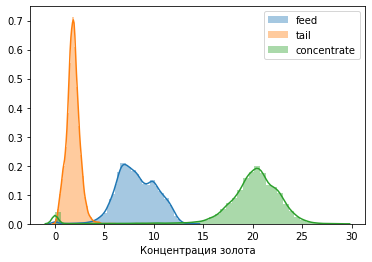

In [15]:
sns.distplot(rougher['rougher.input.feed_au'], hist_kws={'label':'feed'})
sns.distplot(rougher['rougher.output.tail_au'], hist_kws={'label':'tail'})
sns.distplot(rougher['rougher.output.concentrate_au'],hist_kws={'label':'concentrate'})
plt.legend()
plt.xlabel('Концентрация золота')
plt.show()

Полученные распределения близки к нормальному и в своей основе не перекрываются. Предполагая, что отбраковка пустой породы производится заранее и не попадает в цех очистки можно выделить доверительный интервал содержания золота в сырье. Выделим такие данные.

In [16]:
rougher_feed_min = rougher[rougher['rougher.input.feed_au'] != 0]['rougher.input.feed_au'].quantile(0.025)
rougher_feed_max = rougher[rougher['rougher.input.feed_au'] != 0]['rougher.input.feed_au'].quantile(0.975)
display(
'Нижняя граница доверительного интервала содержания золота в сырье равна {:.0f}'.format(rougher_feed_min),
'Верхняя граница доверительного интервала содержания золота в сырье равна {:.0f}'.format(rougher_feed_max))

'Нижняя граница доверительного интервала содержания золота в сырье равна 5'

'Верхняя граница доверительного интервала содержания золота в сырье равна 12'

In [17]:
rougher = rougher[(rougher['rougher.input.feed_au'] >= rougher_feed_min) & 
                  (rougher['rougher.input.feed_au'] <= rougher_feed_max)]

Подготовим функицю для расчета эффективности очистки

In [18]:
def recovery_calc(row):
    feed = row['feed']
    tail = row['tail']
    concentrate = row['concentrate']
    if  tail < feed and tail < concentrate and concentrate > feed:
        recovery = (1 - tail/feed)*(1 - tail/concentrate)*100
    else:
        recovery = None
    return recovery

Выделим данные необходимые для расчета эффективности и проведем его

In [19]:
rougher_recovery = pd.DataFrame()
rougher_recovery['feed'] = rougher['rougher.input.feed_au']
rougher_recovery['tail'] = rougher['rougher.output.tail_au']
rougher_recovery['concentrate'] = rougher['rougher.output.concentrate_au']
rougher_recovery['calculated'] = rougher_recovery.apply(recovery_calc,axis=1)
rougher_recovery = rougher_recovery.join(full['rougher.output.recovery']).dropna()
display(rougher_recovery.head(),rougher_recovery.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17201 entries, 0 to 22712
Data columns (total 5 columns):
feed                       17201 non-null float64
tail                       17201 non-null float64
concentrate                17201 non-null float64
calculated                 17201 non-null float64
rougher.output.recovery    17201 non-null float64
dtypes: float64(5)
memory usage: 806.3 KB


,feed,tail,concentrate,calculated,rougher.output.recovery
0,6.486150,1.170244,19.793808,77.112316,87.107763
1,6.478583,1.184827,20.050975,76.883223,86.843261
2,6.362222,1.162562,19.737170,76.913206,86.842308
3,6.118189,1.079755,19.320810,77.749457,87.226430
4,5.663707,1.012642,19.216101,77.792951,86.688794


None

'Срендняя эффективность черновой очистки золота равна 71'

'Медианная эффективность черновой очистки золота равна 71'

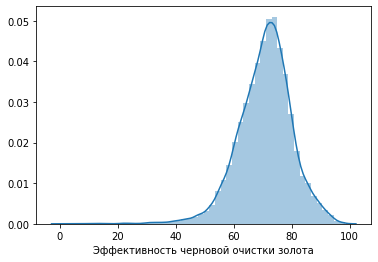

In [20]:
rougher_recovery_mean = rougher_recovery['calculated'].mean()
rougher_recovery_median = rougher_recovery['calculated'].median()
display('Срендняя эффективность черновой очистки золота равна {:.0f}'.format(rougher_recovery_mean),
        'Медианная эффективность черновой очистки золота равна {:.0f}'.format(rougher_recovery_median))
sns.distplot(rougher_recovery['calculated'])
plt.xlabel('Эффективность черновой очистки золота')
plt.show()

In [21]:
rougher_recovery_min = rougher_recovery['calculated'].quantile(0.025)
rougher_recovery_max = rougher_recovery['calculated'].quantile(0.975)
display('Нижняя граница доверительного интервала эффективности черновой очистки золота равна {:.0f}'.
        format(rougher_recovery_min),
       'Верхняя граница доверительного интервала эффективности черновой очистки золота равна {:.0f}'.
        format(rougher_recovery_max))

'Нижняя граница доверительного интервала эффективности черновой очистки золота равна 51'

'Верхняя граница доверительного интервала эффективности черновой очистки золота равна 88'

Посмотрим, на сколько отличаются новые значения эффективности от старых. Расчитаем среднеквадратичную ошибку между старыми и новыми значениями

In [22]:
recovery_droped = rougher_recovery.dropna()
mae = mean_absolute_error(recovery_droped['calculated'],recovery_droped['rougher.output.recovery'])
print(mae)

14.25578145608741


Выделим признаки и проведем их масштабирование

In [23]:
scaler = StandardScaler()
rougher['recovery'] = rougher_recovery['calculated']
rougher.dropna(inplace=True)
rougher_features = rougher.drop(['rougher.output.tail_au',
                                 'rougher.output.concentrate_au',
                                'recovery'],axis=1)
rougher_features[rougher_features.columns] = scaler.fit_transform(rougher_features[rougher_features.columns])

Сформируем целевой признак - эффективность черновой очистки золота

In [24]:
rougher_target = rougher_recovery['calculated']

### 1.3.3 Подготовим данные для расчета конечного концентрата

Проведем процедуры описанные выше для подготовки данных о конечной очистке. Основные признаки уже подготовлены в тестовой выборке куда необходимо добавить только данные об окончательных отвалах и концентрате золота.

In [25]:
final = full.drop(test_droped.columns, axis=1).drop('date', axis=1)
final['tail'] = full['final.output.tail_au']
final['concentrate'] = full['final.output.concentrate_au']
final = final.dropna(subset = ['rougher.input.feed_ag',
                               'rougher.input.feed_pb',
                               'rougher.input.feed_rate',
                               'rougher.input.feed_size',
                               'rougher.input.feed_sol',
                               'rougher.input.feed_au',
                               'tail','concentrate'])
final = nan_filler(final)

Расчитаем окончательную эффективность очистки золота

In [26]:
final_recovery = pd.DataFrame()
final_recovery['feed'] = final['rougher.input.feed_au']
final_recovery['tail'] = final['tail']
final_recovery['concentrate'] = final['concentrate']
final_recovery['calculated'] = final_recovery.apply(recovery_calc,axis=1)
final_recovery = final_recovery.join(full['final.output.recovery']).dropna()
display(final_recovery.head(),final_recovery.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18717 entries, 0 to 22715
Data columns (total 5 columns):
feed                     18717 non-null float64
tail                     18717 non-null float64
concentrate              18717 non-null float64
calculated               18717 non-null float64
final.output.recovery    18717 non-null float64
dtypes: float64(5)
memory usage: 877.4 KB


,feed,tail,concentrate,calculated,final.output.recovery
0,6.486150,2.143149,42.192020,63.556921,70.541216
1,6.478583,2.224930,42.701629,62.236137,69.266198
2,6.362222,2.257889,42.657501,61.096389,68.116445
3,6.118189,2.146849,42.689819,61.646069,68.347543
4,5.663707,2.055292,42.774141,60.649866,66.927016


None

'Средняя эффективность окончательной очистки золота равна 58'

'Медианная эффективность окончательной очистки золота равна 59'

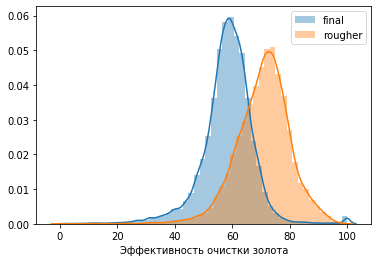

In [27]:
final_recovery_mean = final_recovery['calculated'].mean()
final_recovery_median = final_recovery['calculated'].median()
display('Средняя эффективность окончательной очистки золота равна {:.0f}'.format(final_recovery_mean),
        'Медианная эффективность окончательной очистки золота равна {:.0f}'.format(final_recovery_median))
sns.distplot(final_recovery['calculated'], hist_kws = {'label':'final'})
sns.distplot(rougher_recovery['calculated'], hist_kws = {'label':'rougher'})
plt.legend()
plt.xlabel('Эффективность очистки золота')
plt.show()

На распределении эффективности окончательной очистки золота наблюдается аномальное значение 100%, наиболее вероятно возникающее при нулевой концентрации золота в отвалах. Такое значение вероятно неестественное и соответствует сбою системы регистрации. Найдем такие значения и удалим.

In [28]:
final_recovery.query('tail == 0').head()

,feed,tail,concentrate,calculated,final.output.recovery
77,7.121792,0.0,46.543285,100.0,100.0
358,0.413390,0.0,21.885095,100.0,100.0
2315,6.785848,0.0,25.773495,100.0,100.0
2326,7.395918,0.0,42.984047,100.0,100.0
4682,8.207124,0.0,40.472468,100.0,100.0


In [29]:
final_recovery = final_recovery.query('tail != 0')

Выделим признаки окончательного процесса очистки золота и масштабируем их.

In [30]:
final['recovery'] = final_recovery['calculated']
final.dropna(inplace=True)
final_features = final.drop(['tail','concentrate','recovery'],axis=1)
final_features[final_features.columns] = scaler.fit_transform(final_features[final_features.columns])

Сформируем целевой признак - эффективность окончательной очистки золота

In [31]:
final_target = final_recovery['calculated']

# Выводы по подготовке данных к машинному обучению

Представленные данные содержат дату и время цикла очистки, входные характеристики сырья, выходные характеристики отвалов и материала после очистки, параметры системы очистки, значения эффективности очистки после черновой и окончательной стадии, а так же расчетные соотношения между количеством реагентов и концентрацией золота в продукте. 

Часть данных, такие как дата и время цикла очистки, концентрации сопутствующих элементов (Ag, Pb, sol) в отвалах и конечном продукте, расчетные соотношения между количеством реагентов и концентрацией золота в продукте являются лишними для машинного обучения. Другие: концентрация золота в отвалах или конечном продукте требуется только для расчета эффективности очистки.

Представленные данные содержат пропуски, которые видимо связаны со сбоем измерительного оборудования. Пропуски данных в концентрации элементов не заполняем, т.к. это характеристики специфические и здесь легко ошибиться. Пропуски в параметрах системы очистки заполняем предыдущим или последующим значением, но не более одного подряд.

Скорректированы данные по диапазону концентрации золота в сырье. Удалены нулевые значения, а доверительный 95% интервал составил от 5 до 12.

Проверка формулы расчета эффективности очистки показала грубую ошибку, завышающую эффективность очистки при одинаковых концентрациях в отвалах и конечном продукте. Предложена новая формула (1-T/F)(1-T/C).

# 2. Анализ данных

## 2.1 Изменение концентрации металлов на разных этапах очистки

### 2.1.1 Изменение концентрации серебра на разных этапах очистки

In [32]:
ag = pd.DataFrame()
ag['feed'] = full['rougher.input.feed_ag']
ag['rougher_output'] = full['rougher.output.concentrate_ag']
ag['primary_output'] = full['primary_cleaner.output.concentrate_ag']
ag['final_output'] = full['final.output.concentrate_ag']
ag.dropna(inplace=True)

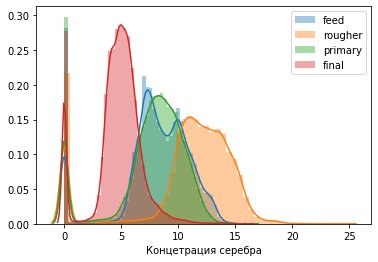

In [33]:
sns.distplot(ag['feed'], hist_kws={'label':'feed'})
sns.distplot(ag['rougher_output'], hist_kws={'label':'rougher'})
sns.distplot(ag['primary_output'], hist_kws={'label':'primary'})
sns.distplot(ag['final_output'], hist_kws={'label':'final'})
plt.legend()
plt.xlabel('Концетрация серебра')
plt.show()

Видно, что после этапа черновой очистки золота концентрация серебра в продукте увеличилась. На снижение содержания серебра в продукте направлены первичная и вторичная системы очистки.

### 2.1.2 Изменение концентрации свинца на разных этапах очистки

In [34]:
pb = pd.DataFrame()
pb['feed'] = full['rougher.input.feed_pb']
pb['rougher_output'] = full['rougher.output.concentrate_pb']
pb['primary_output'] = full['primary_cleaner.output.concentrate_pb']
pb['final_output'] = full['final.output.concentrate_pb']
pb.dropna(inplace=True)

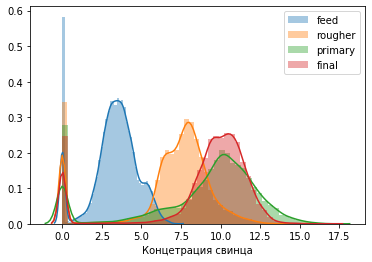

In [35]:
sns.distplot(pb['feed'], hist_kws={'label':'feed'})
sns.distplot(pb['rougher_output'], hist_kws={'label':'rougher'})
sns.distplot(pb['primary_output'], hist_kws={'label':'primary'})
sns.distplot(pb['final_output'], hist_kws={'label':'final'})
plt.legend()
plt.xlabel('Концетрация свинца')
plt.show()

Свинец наиболее близок по массе к золоту, поэтому неудивительно, что концентрация свинца в продукте почти не падает даже после этапа вторичной очистки.

### 2.1.3 Изменение концентрации золей на разных этапах очистки

In [36]:
sol = pd.DataFrame()
sol['feed'] = full['rougher.input.feed_sol']
sol['rougher_output'] = full['rougher.output.concentrate_sol']
sol['primary_output'] = full['primary_cleaner.output.concentrate_sol']
sol['final_output'] = full['final.output.concentrate_sol']
sol.dropna(inplace=True)

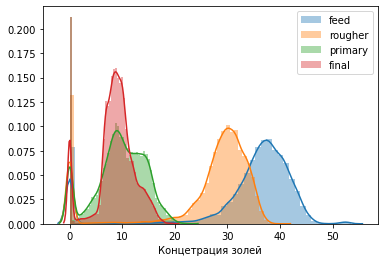

In [37]:
sns.distplot(sol['feed'], hist_kws={'label':'feed'})
sns.distplot(sol['rougher_output'], hist_kws={'label':'rougher'})
sns.distplot(sol['primary_output'], hist_kws={'label':'primary'})
sns.distplot(sol['final_output'], hist_kws={'label':'final'})
plt.legend()
plt.xlabel('Концетрация золей')
plt.show()

Все остальные примеси достаточно хорошо выделяются из объема продукта. Их концентрация снижается на всех этапах очистки. 

### 2.1.3 Изменение концентрации золота на разных этапах очистки

In [38]:
au = pd.DataFrame()
au['feed'] = full['rougher.input.feed_au']
au['rougher_output'] = full['rougher.output.concentrate_au']
au['primary_output'] = full['primary_cleaner.output.concentrate_au']
au['final_output'] = full['final.output.concentrate_au']
au.dropna(inplace=True)

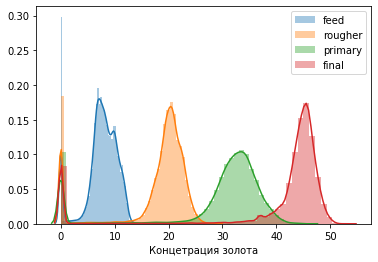

In [39]:
sns.distplot(au['feed'], hist_kws={'label':'feed'})
sns.distplot(au['rougher_output'], hist_kws={'label':'rougher'})
sns.distplot(au['primary_output'], hist_kws={'label':'primary'})
sns.distplot(au['final_output'], hist_kws={'label':'final'})
plt.legend()
plt.xlabel('Концетрация золота')
plt.show()

### Выводы
На основании приведенных выше распределений можно предположить следующие стадии очистки:
1. на этапе черновой очистки удаляются примеси типа золей;
2. на первичном этапе производится очистка продукта от серебра;
3. на вторичном этапе производится очистка продукта от свинца.

## 2.2 Изменение суммарной концентрации веществ на разных этапах очистки

Как мы видели выше: в данных о концентрации элементов присутствуют нулевые значения. Посмотрим появляются эти значения одновременно для всех элементов или система очистки работает настолько хорошо, что полностью удаляет отдельные примеси. Явлются ли такие значения особенностью сырья, или это сбой регистрирующего оборудования.

Построим четыре распределения соответствующие суммарной концентрации основных элементов серебра, свинца и золота в сырье, и на всех этапах очистки.

In [40]:
elements = full[['rougher.input.feed_au',
                 'rougher.input.feed_ag',
                 'rougher.input.feed_pb',
                 'rougher.output.concentrate_au',
                 'rougher.output.concentrate_ag',
                 'rougher.output.concentrate_pb',
                 'primary_cleaner.output.concentrate_au',
                 'primary_cleaner.output.concentrate_ag',
                 'primary_cleaner.output.concentrate_pb',
                 'final.output.concentrate_au',
                 'final.output.concentrate_ag',
                 'final.output.concentrate_pb']].dropna()
elements.columns = ['feed_au','feed_ag','feed_pb',
                    'rougher_au','rougher_ag','rougher_pb',
                    'primary_au','primary_ag','primary_pb',
                    'final_au','final_ag','final_pb']
elements['feed_total'] = elements['feed_au'] + elements['feed_ag'] + elements['feed_pb']
elements['rougher_total'] = elements['rougher_au'] + elements['rougher_ag'] + elements['rougher_pb']
elements['primary_total'] = elements['primary_au'] + elements['primary_ag'] + elements['primary_pb']
elements['final_total'] = elements['final_au'] + elements['final_ag'] + elements['final_pb']

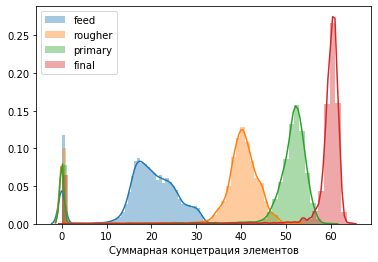

In [41]:
sns.distplot(elements['feed_total'], hist_kws={'label':'feed'})
sns.distplot(elements['rougher_total'], hist_kws={'label':'rougher'})
sns.distplot(elements['primary_total'], hist_kws={'label':'primary'})
sns.distplot(elements['final_total'], hist_kws={'label':'final'})
plt.legend()
plt.xlabel('Суммарная концетрация элементов')
plt.show()

Видно, что на каждом этапе очистки есть аномальное значение соответствующее нулевой концентрации элементов.

In [42]:
elements.query('feed_total == 0').sum()

feed_au             0.000000
feed_ag             0.000000
feed_pb             0.000000
rougher_au        765.341615
rougher_ag        490.789799
rougher_pb        267.429187
primary_au       2438.493253
primary_ag        661.604088
primary_pb        706.243927
final_au         6185.530289
final_ag          999.619529
final_pb         1623.600656
feed_total          0.000000
rougher_total    1523.560602
primary_total    3806.341269
final_total      8808.750473
dtype: float64

In [43]:
elements.query('rougher_total == 0').sum()

feed_au           3819.540512
feed_ag           4065.807820
feed_pb           1678.738262
rougher_au           0.000000
rougher_ag           0.000000
rougher_pb           0.000000
primary_au       15098.583945
primary_ag        3728.493634
primary_pb        4736.734454
final_au         23173.647568
final_ag          2848.507777
final_pb          5329.302826
feed_total        9564.086594
rougher_total        0.000000
primary_total    23563.812033
final_total      31351.458172
dtype: float64

In [44]:
elements.query('primary_total == 0').sum()

feed_au           1512.224099
feed_ag           1628.139295
feed_pb            686.372927
rougher_au        3020.695145
rougher_ag        1781.606107
rougher_pb        1343.257939
primary_au           0.000000
primary_ag           0.000000
primary_pb           0.000000
final_au          8547.316536
final_ag          1291.639636
final_pb          2290.191700
feed_total        3826.736321
rougher_total     6145.559192
primary_total        0.000000
final_total      12129.147871
dtype: float64

In [45]:
elements.query('final_total == 0').sum()

feed_au          1259.824579
feed_ag          1313.960797
feed_pb           545.662991
rougher_au       2518.023906
rougher_ag       1466.919214
rougher_pb       1010.012156
primary_au       2957.967374
primary_ag        734.405671
primary_pb        790.988294
final_au            0.000000
final_ag            0.000000
final_pb            0.000000
feed_total       3119.448367
rougher_total    4994.955277
primary_total    4483.361340
final_total         0.000000
dtype: float64

Видимо, оба предположения имеют место. Часть выбросов связана с пустой породой, в другом случае содержание элементов пропадает на одном этапе, до и после содержание элементов присутствует. Обрабатывать данные аномалии не имеет смысла, так как их наличие уже учтено при расчете эффективности очистки.

## 2.3 Сравнение размеров гранул сырья в обучающей и тестовой выборках

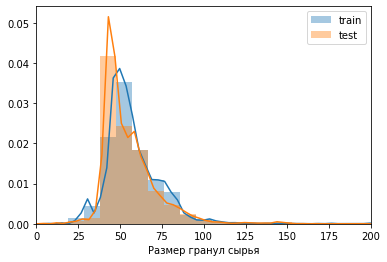

'Средний размер гранул по обучающей выборке равен 59'

'Средний размер гранул по тестовой выборке равен 56'

In [46]:
feed_size_train = train['rougher.input.feed_size'].dropna()
feed_size_test = test['rougher.input.feed_size'].dropna()
sns.distplot(feed_size_train, hist_kws={'label':'train'})
sns.distplot(feed_size_test, hist_kws={'label':'test'})
plt.legend()
plt.xlabel('Размер гранул сырья')
plt.xlim(0,200)
plt.show()
display('Средний размер гранул по обучающей выборке равен {:.0f}'.format(feed_size_train.mean()),
        'Средний размер гранул по тестовой выборке равен {:.0f}'.format(feed_size_test.mean()))

Распределения гранул по обучающей и тестовой выборкам очень близки, a средние значения отличаются примерно на 5%. Проверим гипотезу:
- средний размер гранул в обучающей и тестовой выборках одинаковый.

Так как обе выборки сделаны из одного массива данных, считаем их родственными, а для сравнения применим технику бутстреп, выбирая из обучающей выборки куски размера тестовой выборки.

In [47]:
state = RandomState(12)
count = 0 #количество случаев, когда размер гранул разный
for i in range(1000):
    feed_size_train_sample = feed_size_train.sample(n=len(feed_size_test), random_state = state)
    feed_size_result = st.ttest_rel(feed_size_train_sample,feed_size_test)
    if (feed_size_result.pvalue < 0.05):
        count += 1
print('Размер гранул в обучающей и тестовой выборках разный с вероятностью {:.0%}'.format(count/1000))

Размер гранул в обучающей и тестовой выборках разный с вероятностью 100%


Видимо разделение выборок на обучающую и тестовую было проведено некорректно. Разделим исходный датасет вручную и проверим в нем размер гранул.

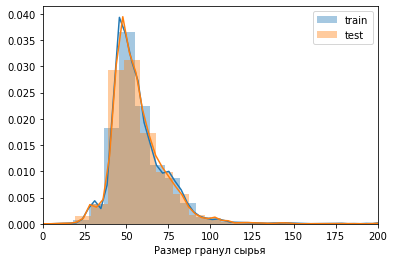

'Средний размер гранул по обучающей выборке равен 58'

'Средний размер гранул по тестовой выборке равен 58'

In [48]:
new_train, new_test = train_test_split(full,test_size=0.25,random_state=1)
feed_size_train = new_train['rougher.input.feed_size'].dropna()
feed_size_test = new_test['rougher.input.feed_size'].dropna()
sns.distplot(feed_size_train, hist_kws={'label':'train'})
sns.distplot(feed_size_test, hist_kws={'label':'test'})
plt.legend()
plt.xlabel('Размер гранул сырья')
plt.xlim(0,200)
plt.show()
display('Средний размер гранул по обучающей выборке равен {:.0f}'.format(feed_size_train.mean()),
        'Средний размер гранул по тестовой выборке равен {:.0f}'.format(feed_size_test.mean()))

In [49]:
count = 0
for i in range(1000):
    feed_size_train_sample = feed_size_train.sample(n=len(feed_size_test), random_state = state)
    feed_size_result = st.ttest_rel(feed_size_train_sample,feed_size_test)
    if (feed_size_result.pvalue < 0.05):
        count += 1
print('Размер гранул в обучающей и тестовой выборках разный с вероятностью {:.0%}'.format(count/1000))

Размер гранул в обучающей и тестовой выборках разный с вероятностью 0%


Действительно в новых выборках размеры гранул совпадают. В представленных ранее данных разделение выборок было проведено не корректно.

# 3. Модель

## 3.1 Функция для вычисления sMAPE

Подготовим функцию оценки качества модели.

In [50]:
def smape(target,prediction):
    return (abs(target - prediction)/((abs(target) + abs(prediction))/2)).mean()

Подготовим на ее основе, функцию расчета итогового качества предсказания эффективности.

In [51]:
def smape_total(target25,prediction25,target75,prediction75):
    return 0.25*smape(target25,prediction25) + 0.75*smape(target75,prediction75)

Сформируем на основе полученной функции метрику качества модели

In [52]:
smape_score = make_scorer(smape,greater_is_better=False)

## 3.2 Обучение модели

Выделим для моделей расчета черновой и конечной эффективности очистки обучающую и тестовую выборки.

In [53]:
(rougher_train_features, 
 rougher_test_features, 
 rougher_train_target,
 rougher_test_target) = train_test_split(rougher_features,
                                         rougher_target,
                                         test_size=0.25,random_state=1)

In [54]:
(final_train_features, 
 final_test_features,
 final_train_target,
 final_test_target) = train_test_split(final_features,
                                       final_target,
                                       test_size=0.25,random_state=1)

Для моделирования выберем две модели: модель Решающего дерева и Случайного леса. Параметры моделей подберем с помощью функции RandomizedSearchCV. В качестве метрики поставим введенную выше smape_score.

In [55]:
tree = DecisionTreeRegressor(random_state=2)
forest = RandomForestRegressor(bootstrap = False, random_state=4)
params = {'max_depth':range(5,35),
          'max_features':np.arange(0.1,1.1,0.1)}

In [56]:
%%time
iterations = 20
model_stats = []
for model in [tree,forest]:
    rougher_search = RandomizedSearchCV(model,params,n_iter = iterations,scoring = smape_score)
    final_search = RandomizedSearchCV(model,params,n_iter = iterations,scoring = smape_score)
    rougher_model = rougher_search.fit(rougher_train_features,rougher_train_target)
    rougher_predictions = rougher_model.predict(rougher_test_features)
    final_model = final_search.fit(final_train_features,final_train_target)
    final_predictions = final_model.predict(final_test_features)
    score = smape_total(rougher_test_target,rougher_predictions,
                        final_test_target,final_predictions)
    model_stats.append([score,
                        rougher_model.best_params_['max_depth'],
                        rougher_model.best_params_['max_features'],
                        final_model.best_params_['max_depth'],
                        final_model.best_params_['max_features']])

CPU times: user 6min 34s, sys: 311 ms, total: 6min 35s
Wall time: 13min 2s


In [57]:
model_stats = pd.DataFrame(model_stats,index=['tree','forest'],
                           columns=['smape',
                                    'rougher_max_depth',
                                    'rougher_max_features',
                                    'final_max_depth',
                                    'final_max_features'])
display(model_stats)

,smape,rougher_max_depth,rougher_max_features,final_max_depth,final_max_features
tree,0.083039,10,0.6,10,0.5
forest,0.061683,31,0.5,34,0.3


Полученные значения метрики smape, для обоих моделей относительно не велики. Сравним их с метрикой константной модели, которая выдает среднее значение эффективности в любых условиях. Как было показано выше средннее и медианное значения эффективности приблизительно равны, поэтому в качестве уровня константной модели выберем среднее значение эффективности.

In [58]:
constant_rougher = pd.DataFrame()
constant_rougher['target'] = rougher_target
constant_rougher['prediction_mean'] = rougher_recovery_mean
constant_final = pd.DataFrame()
constant_final['target'] = final_target
constant_final['prediction_mean'] = final_recovery_mean
display('Величина smape для константной модели {:.2f}'.format(smape_total(
        constant_rougher['target'],constant_rougher['prediction_mean'],
        constant_final['target'],constant_final['prediction_mean'])))

'Величина smape для константной модели 0.11'

Для константной модели метрика так же не велика, но все же больше чем в случае Решающего дерева или Случайного леса.

# Выводы

Представленные данные содержат дату и время цикла очистки, входные характеристики сырья, выходные характеристики отвалов и материала после очистки, параметры системы очистки, значения эффективности очистки после черновой и окончательной стадии, а так же расчетные соотношения между количеством реагентов и концентрацией золота в продукте. 

Часть данных, такие как дата и время цикла очистки, концентрации сопутствующих элементов (Ag, Pb, sol) в отвалах и конечном продукте, расчетные соотношения между количеством реагентов и концентрацией золота в продукте являются лишними для машинного обучения. Другие: концентрация золота в отвалах или конечном продукте требуется только для расчета эффективности очистки.

Представленные данные содержат пропуски, которые видимо связаны со сбоем измерительного оборудования. Пропуски данных в концентрации элементов не заполняем, т.к. это характеристики специфические и здесь легко ошибиться. Пропуски в параметрах системы очистки заполняем предыдущим или последующим значением, но не более одного подряд. Системы регистрации концентрации элементов периодически дают сбой показывая нулевую концентрацию элементов.

Проверка формулы расчета эффективности очистки показала грубую ошибку, завышающую эффективность очистки при одинаковых концентрациях в отвалах и конечном продукте. Предложена новая формула (1-T/F)(1-T/C).

Анализ данных выявил следующие стадии очистки:
1. на этапе черновой очистки удаляются примеси типа золей;
2. на первичном этапе производится очистка продукта от серебра;
3. на вторичном этапе производится очистка продукта от свинца.

Анализ предложенных обучающей и тестовой выборок показал, что размер гранул сырья в выборках не одинаковый из-за этого результаты обучения модели могут быть не корректные. Поэтому новые выборки были сделаны из основного датасета.

Для создания модели были выбраны DecisionTreeRegressor и RandomForestRegressor. Полученные значения метрики smape, для обоих моделей относительно не велики, 8 и 6% соответственно. При этом константная модель, в которой заложено среднее значение эффективности для любых условий дает величину метрики в 1,5 - 2 раза выше, что положительно характеризует полученные модели.